# UNDERSTANDING GNN EXPLAINER

In this tutorial we are going to explore how GNN Explainer works by breaking it down in pieces that will hopefully make it more intuitevely understandable.

The goal of this is to get a full understanding of the method such that the user can expand it to its use.

We will work on the Cora dataset to show all the steps involved, and the model that we will explain is a small GCN model.

In [96]:
#Here we import the necessary libraries
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch

#for the model 
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

#Explain Module
import torch.nn as nn
import math

#to import the data
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx

In [3]:
#Here we import the Cora dataset. We use the Cora dataset because it is a small dataset and it is easy to understand.
#We import the dataset from the Pytorch Geometric library as it is already preprocessed - and the goal is then to further expand the GNN implementation to other datasets starting from the PYG implementation.

#import the dataset and print some information about it
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
print('dataset under study')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')


Number of graphs: 1
Number of features: 1433
Number of classes: 7
dataset under study
Number of nodes: 2708
Number of edges: 10556


In [37]:
#for convention to how things are named we rename the data
label = data.y
feat = data.x

Since we want to visualize the graph, we need to convert the data into a networkx graph. We can then use the networkx library to visualize the graph. Each node color represents a different class in the dataset.

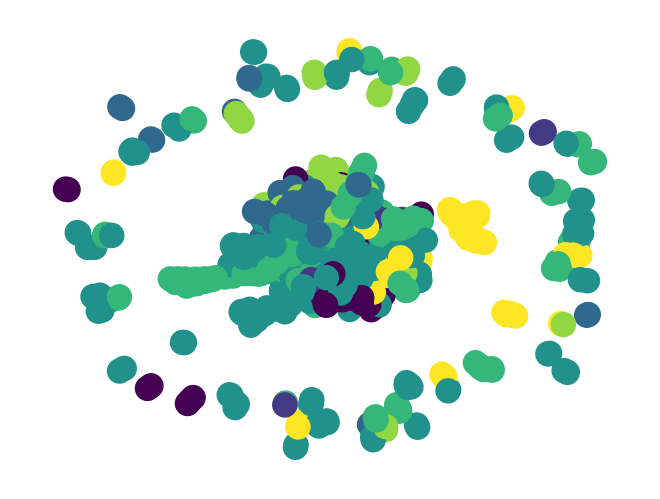

In [8]:

G = to_networkx(data, to_undirected=True)
nx.draw(G, with_labels=False, node_color=data.y)

Another cool thing about importing our graph into a networkx object is that we can easily extract its adjacency matrix - which we will need to dig into the GNN Explainer method.

We can easily see from the Adjacency matrix that the graph is directed as adj is not symmetric, but indeed as it should be is a square matrix.

Just a reminder: what is an Adjacency matrix of a graph?

It is a matrix where each row correspond to a node, and the row/column combination represent the connectivity between two nodes. 
In particular for node 1, we can see that it has a connection towards node 2, because it is a non zero element of the node 1 row.


In [21]:
adj = nx.adjacency_matrix(G).todense()
print('Connectivity for node 1: \n we can see that it is connected to node 2',adj[1][0:10])

Connectivity for node 1: 
 we can see that it is connected to node 2 [0 0 1 0 0 0 0 0 0 0]


We are now ready to start exploring the GNN Explainer implementation.

The explain module (explain.py) is made of two classes:
- ExplainModule - which is a nn.Module
- Explainer - which uses ExplainModule to perform the explanation

# Class Explainer:
explain: Given a node index it returns the masked adjacency matrix for that node:
1. Extract the neighborhood of the given node
2. Get the original label of the node
3. Get the predicted label of the node (argmax from the softmax layer of the network)
4. Call the ExplainModule to do the dirty jobs

1. Extract the neighborhood of the given node
- We are interested in getting a neighborhood not just in terms of actual neighbors but also in terms of potentian neighbors - namely node which are not directly connected but they would be connected if we consider a different number of hops.

- For instance in a simple graph a-b-c: a is connected to c if we consider 2 hops.

- We want to have a function that gets that for all our graph - so we rely on the adjacency matrix and we modify it according to the number of hops that we want to take into consideration.

- We add self loops as well in terms of connections

#from graph_utils import neighborhoods

In [42]:
#line 147 in utils/graph_utils.py
def neighborhoods(adj, n_hops):
    """Returns the n_hops degree adjacency matrix adj."""

    adj = torch.tensor(adj, dtype=torch.float)
    hop_adj = power_adj = adj
    for i in range(n_hops - 1):
        power_adj = power_adj @ adj
        prev_hop_adj = hop_adj
        hop_adj = hop_adj + power_adj
        #print(type(hop_adj))
        hop_adj = (hop_adj > 0).float()
        #print(hop_adj)
    return hop_adj.cpu().numpy().astype(int)
n_hops = 2
adj_hop = neighborhoods(adj, n_hops)
print(' 2 hops Connectivity for node 1: \n we can see that it is connected to node 2',adj_hop[1,:])


 2 hops Connectivity for node 1: 
 we can see that it is connected to node 2 [0 1 1 ... 0 0 0]


### Extract neighborhood
We are simplifying the function as we are working with 1 graph only (indeed we are working on node mode)

Extract neighborhood which returns the new index node, the adjacency matrix of the neighboor, the features of the neighboor, the label and the actual neighbors.


- So the neighbors are indeed the neighbros as defined to be the neighbors according to the number of hops used
- the sub adj: is the adjacency matrix of the neighbors (adjacency where select only row and cols of the neighbor ) -- thus its size depends on how many neighbors the node has
- new index usually just zero

In [51]:
#line 506 in explain.py

def extract_neighborhood(node_idx,adj,feat,label,n_hops):
    """Returns the neighborhood of a given ndoe."""
    neighbors_adj_row = neighborhoods(adj,n_hops)[node_idx, :] #take row of the node in the new adj matrix
    # index of the query node in the new adj
    node_idx_new = sum(neighbors_adj_row[:node_idx]) #sum of all the nodes before the query node (since they are 1 or 0) - it becomes count of nodes before the query node
    neighbors = np.nonzero(neighbors_adj_row)[0] #return the indices of the nodes that are connected to the query node (and thus are non zero)
    sub_adj = adj[neighbors][:, neighbors]
    sub_feat = feat[neighbors]
    sub_label = label[neighbors]
    return node_idx_new, sub_adj, sub_feat, sub_label, neighbors

node_idx_new, sub_adj, sub_feat, sub_label, neighbors = extract_neighborhood(1,adj,feat,label,n_hops)
node_idx_new, sub_adj, sub_feat, sub_label, neighbors

(0,
 array([[0, 1, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 1, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([4, 4, 3, 4, 4, 4, 4, 3, 3]),
 array([   1,    2,  332,  470,  652,  654, 1454, 1666, 1986]))

Now we can visualize the neighbors for a given node and for a given number of hops!

Due to the message passing idea of GNN, this is the structure which is going to be the most influential for the node classification task (namely: number of hops more and less corresponds to the number of layers in our model - IS IT CORRECT???)


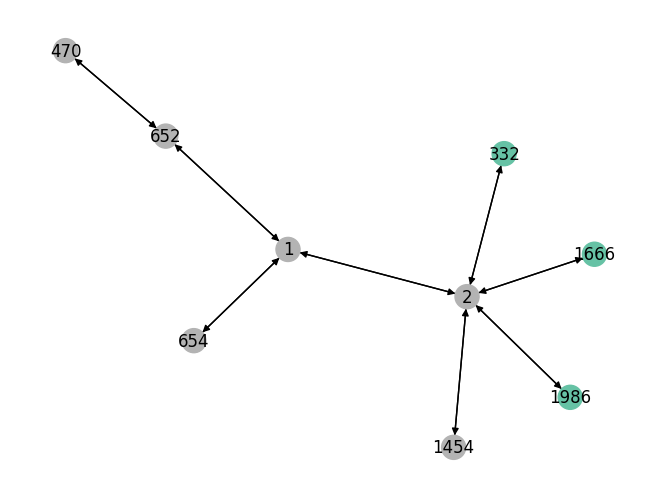

In [166]:

def visualize_hop_neighbor_subgraph(node_idx, data, neighbors, n_hops,adj,feat,label):
    """Visualizes the n-hop neighborhood of a given node."""
    node_idx_new, sub_adj, sub_feat, sub_label, neighbors = extract_neighborhood(node_idx,adj,feat,label,n_hops)
    subdata = data.subgraph(torch.tensor(neighbors))
    subindex = subdata.edge_index
    Gsub = G = to_networkx(subdata, to_undirected=False)
    labeldict = {}
    for i,j in zip(range(len(neighbors)),neighbors):
        labeldict[i] = j
    nx.draw(Gsub, labels = labeldict, node_color = data.y[neighbors], cmap="Set2")
    return subdata, subindex


node_idx = 1
subdata_Data, subindex = visualize_hop_neighbor_subgraph(node_idx, data, neighbors, 2,adj,feat,label)
subdata = subdata_Data.x


2. Get the original label of the node - we already have it 
3. Get the predicted label of the node:

A. Here is where we have to start thinking about the model that we want to explain.
In this next section we will thus implement a very straight - forward GCN model adapted to how the models in GNN explainer have been designed. 

B. Another option implies taking a very straightforward model and then modify the structure of the explainer such that we can actually use that model


For the sake of simplicity we first work on B.

In [93]:
#This module is directly taken from the Pytorch Geometric tutorial on node classification

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)


model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 401):
    loss = train()

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}') 


model.eval()
torch.save(model, 'model_cora')
pred = model(data.x, data.edge_index)
pred_label = pred.argmax(dim=1)


#we will only be interested in the predicted labels for the neighbirhood of the query node
print(f'Predicted labels for node index, {node_idx} with hops {n_hops}: \n ',pred_label[neighbors], 
      f'\n Actual labels for node index, {node_idx} with hops {n_hops}: \n ',data.y[neighbors])


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Test Accuracy: 0.8080
Predicted labels for node index, 1 with hops 2: 
  tensor([4, 4, 4, 4, 4, 4, 4, 4, 3]) 
 Actual labels for node index, 1 with hops 2: 
  tensor([4, 4, 3, 4, 4, 4, 4, 3, 3])


So now we have the predicted labels for each node stored in pred.
4. Call the ExplainModule into an obejct : we will have to dig in the ExplainModule class before going forward with the explanation of the Explainer module

# Explain Module
inputs: adj, x, model, label 

1. get mask and mask bias -> construct edge_mask (line 656) - in a similar way the feature masks are initialized

->Mask are a torch.nn.parameter.Parameter object randomly initialized with dimension equal to the number of nodes in the neighborhood x number of nodes in the neighborhood (according to different initialization strategies: normal and constant are defined)

Feature mask built in a similar way : the size of the nn.Parameter is the size of the last dimension of x (and thus the number of features for the node)
Diagonal mask is a  tensor of 1s with 0s on the diagonal 

2. Forward function ( line 703 )
Masked adjacency : (_masked_asdj) is the non linear activated mask (sym_mask: it is symmetric because we add its transpose and then divide by 2) multiplied by the adjacency matrix and the diagonal mask (in this way the diagonal elements are 0s out) -> remember that the adjacency matrix we see here is the one of the neighborhood already so the shapes match 
??? So the whole idea about masking is that we perturbate the adjacency matrix  - so that the values inside the matrix are not 0s and 1s but can get different values (according to the initialization)
Then in the forward:
Ypred and adj_att are the model prediction on the node given the masked adjacency matrix (we take the softmax of the node prediction - so the result is a vector of probabilities - and we will be able to inquire how the probability of the correct class change given that we did perturb the graph)

## Mask functions


In [100]:
#Num nodes: is how many nodes in the neighborhood (computed as the sum of 1s over the row of the node of interest - as there is a 1 only if the node is connected to other nodes)

num_nodes = len(neighbors)
diag_mask = torch.ones(num_nodes, num_nodes) - torch.eye(num_nodes) #create a diag mask of 1 and 0s on the diagonal


In [98]:
def construct_edge_mask( num_nodes, init_strategy="normal", const_val=1.0):
    """
    Construct edge mask
    input;
        num_nodes: number of nodes in the neighborhood
        init_strategy: initialization strategy for the mask
        const_val: constant value for the mask
    output:
        mask: edge mask    
    """
    mask = nn.Parameter(torch.FloatTensor(num_nodes, num_nodes))  #initialize the mask
    if init_strategy == "normal":
        std = nn.init.calculate_gain("relu") * math.sqrt(
            2.0 / (num_nodes + num_nodes)
        )
        with torch.no_grad():
            mask.normal_(1.0, std)
    elif init_strategy == "const":
        nn.init.constant_(mask, const_val)
    return mask

edge_mask = construct_edge_mask(num_nodes, init_strategy="normal", const_val=1.0)
#edge mask is a matrix of size num_nodes x num_nodes initialized with random values from a normal distribution with mean 1 and std calculated using the formula given 

In [115]:
feat_dim = data.num_features
def construct_feat_mask( feat_dim, init_strategy="normal"):
    """
    Construct feature mask
    input:
        feat_dim: dimension of the feature
        init_strategy: initialization strategy
    output:
        mask: feature mask    
    """
    mask = nn.Parameter(torch.FloatTensor(feat_dim))
    if init_strategy == "normal":
        std = 0.1
        with torch.no_grad():
            mask.normal_(1.0, std)
    elif init_strategy == "constant":
        with torch.no_grad():
            nn.init.constant_(mask, 0.0)
            # mask[0] = 2
    return mask

feat_mask = construct_feat_mask(feat_dim, init_strategy="normal")

#feat mask is a vector of size feat_dim initialized with random values from a normal distribution with mean 1 and std 0.1 (if normal strategy is chosen)

In [116]:
def _masked_adj(mask,adj, diag_mask):
    """ Masked adjacency matrix 
    input: edge_mask, sub_adj, diag_mask
    output: masked_adj
    """
    sym_mask = mask
    sym_mask = torch.sigmoid(mask)
    
    sym_mask = (sym_mask + sym_mask.t()) / 2
    adj = torch.tensor(adj)
    masked_adj = adj * sym_mask

    return masked_adj * diag_mask

masked_adj = _masked_adj(edge_mask,sub_adj, diag_mask)
masked_adj
print('original sub_adj: \n', torch.tensor(sub_adj), '\n masked_adj: \n', masked_adj)


original sub_adj: 
 tensor([[0, 1, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 1, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0]]) 
 masked_adj: 
 tensor([[0.0000, 0.7837, 0.0000, 0.0000, 0.8310, 0.6591, 0.0000, 0.0000, 0.0000],
        [0.7837, 0.0000, 0.7155, 0.0000, 0.0000, 0.0000, 0.5759, 0.5290, 0.7932],
        [0.0000, 0.7155, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8270, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8310, 0.0000, 0.0000, 0.8270, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6591, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5759, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5290, 0.0000, 0.0000, 0.0000, 0.0000,

The whole idea of masking the adjacency matrix is to add perturbations in the node connections - they are not connected with the same weights anymore.

### Forward
The method takes several arguments, but the most important one is node_idx, which appears to be the index of a node in a graph. The purpose of this method is to generate a prediction for that node, based on its features and the features of its neighbors, in the form of a softmax output.

The method first checks whether the adjacency matrix should be constrained (i.e. symmetrical) or unconstrained, and generates a masked adjacency matrix accordingly. If the mask_features flag is set, it also masks the input features. If the marginalize flag is set, it generates a random noise vector and scales it according to the feature mask.

The method then passes the masked input features and masked adjacency matrix to a model, which generates a prediction for the target node. If the graph_mode flag is set, it applies a softmax to the entire output, whereas if it is not set, it extracts the prediction for the target node and applies a softmax to that.

Finally, the method returns the softmax output and the adjacency matrix attention, which may be used for visualization or analysis purposes.

In [134]:
#Here we predict the labels for the neighborhood of the query node using the neighborhood subgraph only
#We are indeed not using the masked_adj matrix here


new_pred = model(subdata, subindex)
new_pred_label = new_pred.argmax(dim=1)
print(f'\n Actual labels for node index, {node_idx} with hops {n_hops}: \n ',data.y[neighbors],
    f'\n Predicted labels for node index, {node_idx} with hops {n_hops}: \n ',pred_label[neighbors], 
      f'\n Predicted labels for node index, {node_idx} with hops {n_hops} using subgraph: \n ',new_pred_label)


 Actual labels for node index, 1 with hops 2: 
  tensor([4, 4, 3, 4, 4, 4, 4, 3, 3]) 
 Predicted labels for node index, 1 with hops 2: 
  tensor([4, 4, 4, 4, 4, 4, 4, 4, 3]) 
 Predicted labels for node index, 1 with hops 2 using subgraph: 
  tensor([4, 4, 4, 4, 4, 4, 4, 4, 3])


This kind of work would only imply an investigation of the change in prediction power given only the neighborhood of the query node. Would that be meaningful? Not sure - but I don't really think so :')

Thus let's explore approach A instead.

Let's try to make the model that they use simpler and more understandable for our goal.

In [360]:
#simplified from models.py - we are interested in the node encoder only!
class GraphConv(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    Simplified version of GraphConv in line 9 of models.py
    """

    def __init__(
            self,
            input_dim,
            output_dim):
        super(GraphConv, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        self.bias = None

    def forward(self, x, adj):
        print('adj: ', adj.shape,'x: ', x.t().shape)
        if adj.shape[1] != x.shape[0]:
            x = x.t()
        else:
            x = x
            
        y = torch.matmul(adj, x)
        print('y: ', y.shape, 'weight: ', self.weight.shape)
        if y.shape[1] != self.weight.shape[0]:
            y = y.t()
        else:
            y=y    
        #y = torch.matmul(y,self.weight.long())
        y = torch.matmul(y,self.weight.long())
        return y, adj
    
#The GraphConv layer is a simple GCN layer that takes in the input features and the adjacency matrix and returns the output features and the adjacency matrix

class GcnEncoderNode(nn.Module):
    """ 
    Simplified version of GCN encoder for node prediction
    """

    def __init__(
            self,
            input_dim,
            hidden_dim, 
            embedding_dim,
            label_dim,
            output_dim,
            num_layers):
        
        super(GcnEncoderNode, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.celoss = nn.CrossEntropyLoss()
        self.act = nn.ReLU()
        self.label_dim = label_dim

        self.pred_input_dim = embedding_dim
        pred_hidden_dims = [hidden_dim, hidden_dim]

        self.pred_model = self.build_pred_layers(
            self.pred_input_dim, pred_hidden_dims, embedding_dim, label_dim)

        self.conv_first, self.conv_block, self.conv_last = self.build_conv_layers(
            input_dim,
            hidden_dim,
            embedding_dim,
            num_layers
        )

    def build_conv_layers(
        self,
        input_dim,
        hidden_dim,
        embedding_dim,
        num_layers
    ):
        conv_first = GraphConv(
            input_dim=input_dim,
            output_dim=hidden_dim
        )
        conv_block = nn.ModuleList(
            [
                GraphConv(
                    input_dim=hidden_dim,
                    output_dim=hidden_dim
                )
                for i in range(num_layers - 2)
            ]
        )
        conv_last = GraphConv(
            input_dim=hidden_dim,
            output_dim=embedding_dim
        )
        return conv_first, conv_block, conv_last
    
    def build_pred_layers(
        self, pred_input_dim, pred_hidden_dims, label_dim, num_aggs=1
    ):
        pred_input_dim = pred_input_dim * num_aggs
        if len(pred_hidden_dims) == 0:
            pred_model = nn.Linear(pred_input_dim, label_dim)
        else:
            pred_layers = []
            for pred_dim in pred_hidden_dims:
                pred_layers.append(nn.Linear(pred_input_dim, pred_dim))
                pred_layers.append(self.act)
                pred_input_dim = pred_dim
            pred_layers.append(nn.Linear(pred_dim, label_dim))
            pred_model = nn.Sequential(*pred_layers)
            print(pred_model)
        return pred_model

    def gcn_forward(self, x, adj, conv_first, conv_block, conv_last):
        """ Perform forward prop with graph convolution.
        Returns:
            Embedding matrix with dimension [batch_size x num_nodes x embedding]
            The embedding dim is self.pred_input_dim
        """
        x, adj_att = conv_first(x.t(), adj)
        print(x.shape, adj_att.shape)
        x = self.act(x)
        x_all = [x]
        adj_att_all = [adj_att]
        for i in range(len(conv_block)):
            if x.shape[1] != adj_att.shape[0]:
                x = x.t()
            x, _ = conv_block[i](x, adj)
            x = self.act(x)
            x_all.append(x)
            adj_att_all.append(adj_att)
            print('x shape',x.shape, 'adj shape',adj_att.shape)
        #x, adj_att = conv_block(x, adj)   
        if x.shape[1] != adj_att.shape[0]:
            x = x.t()
        x, adj_att = conv_last(x, adj)
        x_all.append(x)
        adj_att_all.append(adj_att)   
        x_tensor = torch.cat(x_all, dim = -2)
        self.embedding_tensor = x_tensor
        adj_att_tensor = torch.stack(adj_att_all, dim= -3)
        return x_tensor, adj_att_tensor
        #return x_all, adj_att_all
    


    # def forward(self, x, adj):
    #     self.adj_atts = []
    #     self.embedding_tensor, adj_att = self.gcn_forward(
    #         x, adj, self.conv_first, self.conv_block, self.conv_last )
    #     pred = self.pred_model(self.embedding_tensor)
    #     print('pred',pred)
    #     return pred, adj_att
    def forward(self, x, adj):
        self.adj_atts = []
        if adj.shape[1] != x.shape[0]:
            x = x.t()
        else:
            x = x    
        self.embedding_tensor, adj_att = self.gcn_forward(
            x, adj, self.conv_first, self.conv_block, self.conv_last )
        pred = self.pred_model(self.embedding_tensor)
        print('pred',pred)
        return pred, adj_att




In [161]:
sub_feat.shape
sub_adj.shape

(9, 9)

Ok so now we have to use the simplified version of this fancy more to make some training ---> then we want to try and explain this trained boy with the GNN Explainer simplified method. 


Let's see if everything will work out well :)

In [361]:
#to work around this - lets go and have a look at how they use this boy in the train.py 

model = GcnEncoderNode(input_dim= data.num_node_features,
            hidden_dim = 16, 
            embedding_dim = 16,
            label_dim = dataset.num_classes,
            output_dim = dataset.num_classes,
            num_layers = 3)
print(model)




Sequential(
  (0): Linear(in_features=112, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=16, bias=True)
)
GcnEncoderNode(
  (celoss): CrossEntropyLoss()
  (act): ReLU()
  (pred_model): Sequential(
    (0): Linear(in_features=112, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
  )
  (conv_first): GraphConv()
  (conv_block): ModuleList(
    (0): GraphConv()
  )
  (conv_last): GraphConv()
)


In [334]:
# sub_adj =torch.tensor(sub_adj).long()
# sub_feat = torch.tensor(sub_feat).long()
subdata_Data.y[subdata_Data.train_mask]
sub_adj= sub_adj.type(torch.LongTensor)
sub_feat = sub_feat.type(torch.LongTensor)
y = torch.matmul(sub_adj,sub_feat)
#y = torch.matmul(y,    model.conv_first.weight)
sub_feat.shape

torch.Size([9, 1433])

In [373]:
torch.matmul(sub_adj,sub_feat).shape
subdata_Data.y[subdata_Data.train_mask]
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [378]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
#sub_adj =torch.tensor(sub_adj)
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      print('sub_feat shape',sub_feat.shape,'sub_adj shape', sub_adj.shape)
      
      out = model(torch.tensor(data.x).long(), torch.tensor(adj).long())  # Perform a single forward pass.
      print(out.shape)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(torch.tensor(data.x), adj) 
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 401):
    loss = train()

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}') 

sub_feat shape torch.Size([9, 1433]) sub_adj shape torch.Size([9, 9])
adj:  torch.Size([2708, 2708]) x:  torch.Size([2708, 1433])


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_85716/2647091681.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(data.x).long(), torch.tensor(adj).long())  # Perform a single forward pass.


y:  torch.Size([2708, 1433]) weight:  torch.Size([1433, 16])
torch.Size([2708, 16]) torch.Size([2708, 2708])
adj:  torch.Size([2708, 2708]) x:  torch.Size([2708, 16])
y:  torch.Size([2708, 16]) weight:  torch.Size([16, 16])
x shape torch.Size([2708, 16]) adj shape torch.Size([2708, 2708])
adj:  torch.Size([2708, 2708]) x:  torch.Size([2708, 16])
y:  torch.Size([2708, 16]) weight:  torch.Size([16, 16])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8124x16 and 112x16)

In [362]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
#sub_adj =torch.tensor(sub_adj)
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      print('sub_feat shape',sub_feat.shape,'sub_adj shape', sub_adj.shape)
      out = model(sub_feat, sub_adj)  # Perform a single forward pass.
      print(out.shape)
      loss = criterion(out[subdata_Data.train_mask], subdata_Data.y[subdata_Data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(sub_feat, sub_adj) 
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[subdata_Data.test_mask] == subdata_Data.y[subdata_Data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 401):
    loss = train()

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}') 

sub_feat shape torch.Size([9, 1433]) sub_adj shape torch.Size([9, 9])
adj:  torch.Size([9, 9]) x:  torch.Size([9, 1433])
y:  torch.Size([9, 1433]) weight:  torch.Size([1433, 16])
torch.Size([9, 16]) torch.Size([9, 9])
adj:  torch.Size([9, 9]) x:  torch.Size([9, 16])
y:  torch.Size([9, 16]) weight:  torch.Size([16, 16])
x shape torch.Size([9, 16]) adj shape torch.Size([9, 9])
adj:  torch.Size([9, 9]) x:  torch.Size([9, 16])
y:  torch.Size([9, 16]) weight:  torch.Size([16, 16])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (27x16 and 112x16)

In [372]:
def train(model, optimizer, criterion, dataloader):
    model.train()
    train_loss = 0
    train_acc = 0
    total = 0

    for i, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        adj = sub_adj
        x, y = dataloader.x, dataloader.y
        pred, adj_att = model(x, adj)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (pred.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_loss /= len(dataloader)
    train_acc /= total

    return train_loss, train_acc



optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    train_loss, train_acc = train(model, optimizer, criterion, subdata_Data)
    print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.4f}'.format(epoch, train_loss, train_acc))


adj:  torch.Size([9, 9]) x:  torch.Size([9, 1433])


RuntimeError: expected scalar type Long but found Float

In [371]:
subdata_Data.x.shape[1]

1433

In [139]:
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(GraphConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = nn.Parameter(torch.Tensor(in_channels, out_channels))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.glorot(self.weight)
        nn.zeros(self.bias)

    def forward(self, x, edge_index, edge_weight=None):
        """
        Args:
            x (Tensor): Node feature matrix with shape [num_nodes, in_channels].
            edge_index (LongTensor): Graph connectivity in COO format with shape
                [2, num_edges] and type torch.long.
                edge_weight (Tensor, optional): Edge weight tensor with shape
                [num_edges] and type x.dtype. (default: :obj:`None`)
        """
        x = torch.matmul(x, self.weight)
        row, col = edge_index
        out = torch.zeros(x.size(0), self.out_channels, device=x.device)
        out = out.scatter_add_(0, col.unsqueeze(1).repeat(1, self.out_channels), x[row])
        if self.bias is not None:
            out = out + self.bias
        return out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)
    
model1 = GCNConv(data.num_features, 16)    
model.eval()

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [ ]:
def forward(subdata, subindex):
    ypred = model(subdata, subindex)
    node_pred = ypred[subindex, :]
    res = nn.Softmax(dim=0)(node_pred)
    return res

new_pred = forward(subdata, subindex)